### Execrise 16:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt

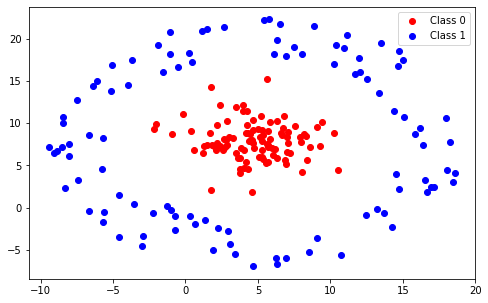

In [2]:
# Synthenic data (Annulus data)
m_ = 100

mu = np.array([5,8])
sigma = np.array([[5,0],[0,5]])
X1 = np.random.multivariate_normal(mu,sigma,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 10 + np.random.uniform(0,5,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)

plt.figure(figsize = (8,5))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')
plt.legend()
plt.show()

In [3]:
X1.shape,X2.shape

((100, 2), (100, 2))

#### SVM prediction using Kernel
- Traing data:$X \in R^{n}, y = \{-1,1\}$
$$
2D: \mathbf{X} = \begin{vmatrix}x_{1}^{1} & x_{2}^{1} \\x_{1}^{2} & x_{2}^{2}\\: & :\\x_{1}^{m} & x_{2}^{m}\end{vmatrix} , \mathbf{y} = \begin{vmatrix} -1\\-1\\:\\1\end{vmatrix}
$$

In [4]:
# Training data
X = np.concatenate((X1,X2),0)
y = np.concatenate((-np.ones((m_,1)),np.ones((m_,1))),0)
m = X.shape[0]
n = np.unique(y).shape[0]

In [5]:
X.shape,y.shape

((200, 2), (200, 1))

**Kernel:**

$$\small \text{Linear Kernel: $\mathcal k(x,x^{'}) = x_{1}x_{1}^{'}+x_{2}x_{2}^{'}+...+x_{n}x_{n}^{'}$} $$
$$\small \text{Polynomial Kernel: $\mathcal k(x,x^{'}) = x_{1}^{2}x_{1}^{'2}+x_{2}^{2}x_{2}^{'2}+...+x_{n}^{2}x_{n}^{'2}$} $$
$$\small \text{RBF Kernel (Radial Basis Function): $\mathcal k(x,x^{'}) = \mathrm{e}^{\frac{-||x-x^{'}||^{2}}{2\sigma^{2}}} \\ 
K = \underbrace{\begin{vmatrix}K(x^{1},x^{1}) & K(x^{1},x^{2}) & .. & K(x^{1},x^{m}) \\K(x^{2},x^{1}) & K(x^{2},x^{2}) & .. & K(x^{2},x^{m})\\: & :& :\\K(x^{m},x^{1}) & K(x^{m},x^{2}) & .. & K(x^{m},x^{m})\end{vmatrix}}_{m \times m} $}$$

In [6]:
# Kernel
def linear_kernel (X):
    return X@X.T

def rbf_kernel (X,sigma):
    m = X.shape[0]
    K = np.zeros((m,m))
    for i in range (m):
        for j in range (m):
            K[i,j] = (X[i,:]-X[j,:])@(X[i,:]-X[j,:])
    K = np.exp(-K/(2*sigma**2))
    return K

**General Quadratic Programming**
$$x^{*} = arg \min_{x}\frac{1}{2}x^{T}Qx+c^{T}x+r $$ $$\text{Subject to : $Ax \leq b\\ Ex = d$}$$
- **cvxopt**.solvers.qp(P,q,G,h,A,b) find the **sol['x']**

**Dual Lagrangian Optimization Problem:**
$$ \mathcal W(\alpha) = \min_{\alpha} \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_{i}\alpha_{j}y^{(i)}y^{(j)}\mathcal k(x,x^{'}) - \sum_{i=1}^{m}\alpha_{i} $$
$$\text{Such that: $-\alpha_{i} \le 0, i \in 1...m \\ \sum_{i=1}^{m}\alpha_{i}y^{(i)} = 0 $}$$

$$
Q=y^{(i)}y^{(j)}\mathcal k(x,x^{'}) ; 
c = \underbrace{\begin{vmatrix} -1\\-1\\:\\-1\end{vmatrix}}_{m \times 1} ; 
A = \underbrace{\begin{vmatrix}-1 & 0 & .. & 0 \\0 & -1 & .. & 0\\: & :& :\\0 & 0 & .. & -1\end{vmatrix}}_{m \times m} ; 
b =\underbrace{\begin{vmatrix}0\\0 \\:\\0\end{vmatrix}}_{m \times 1} ; 
E = \underbrace{\begin{vmatrix}y_{1} & y_{2} & .. & y_{m}\end{vmatrix}}_{1 \times m} ; d = 0
$$

In [12]:
# Set Q,c,A,b,E,d
rbf_sigma = 1
Q = y@y.T*rbf_kernel(X,rbf_sigma)
c = -np.ones((m,1))
A = -np.eye((m))
b = -np.zeros((m,1))
E = y.T
d = np.zeros((1,1))

# Define cvxopt_solvers_qp function
def cvxopt_solvers_qp(Q,c,A=None,b=None,E=None,d=None):
    Q = .5*(Q+Q.T) # make Q is symmetric
    agrs = [cvxopt.matrix(Q),cvxopt.matrix(c)]
    if A is not None:
        agrs.extend([cvxopt.matrix(A),cvxopt.matrix(b)])
    if E is not None:
        agrs.extend([cvxopt.matrix(E),cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*agrs)
    return np.array(sol['x']).reshape(Q.shape[1])
opt_params = cvxopt_solvers_qp(Q,c,A,b,E,d)

     pcost       dcost       gap    pres   dres
 0: -2.5468e+01 -8.1779e+01  6e+01  2e-15  2e+00
 1: -2.8017e+01 -3.3962e+01  6e+00  5e-15  3e-01
 2: -2.9138e+01 -3.0305e+01  1e+00  8e-15  4e-02
 3: -2.9300e+01 -2.9526e+01  2e-01  4e-15  3e-03
 4: -2.9342e+01 -2.9381e+01  4e-02  1e-14  2e-04
 5: -2.9351e+01 -2.9358e+01  6e-03  2e-14  1e-05
 6: -2.9353e+01 -2.9354e+01  6e-04  1e-14  1e-07
 7: -2.9353e+01 -2.9353e+01  2e-05  1e-14  3e-09
Optimal solution found.


In [14]:
#print('Alphas that are not zero:', opt_params[opt_params>1e-5])
#print('Corresponding label:\n',y[opt_params>1e-5])

**Find b**:

$\mathcal S \small \text{ is the set of indexes of the support vectors: } \mathcal S = \{ i \in 1..m | \alpha_{i} > 0 \}; N_{\mathcal S} = len(\mathcal S)$

$$b =\frac{1}{N_{\mathcal S}}\sum_{i \in \mathcal S} \left(y^{(i)} - \sum_{j \in \mathcal S}\alpha_{j}y^{(j)} \mathcal k(x,x^{'}) \right)$$

In [46]:
# define find_b_w function
def find_b (X,y,alpha,rbf_sigma):
    S = np.where(alpha>1e-5)[0] #[0] make S become a numpy array
    X_s = X[S,:]
    y_s = y[S]
    alphas = alpha[S].reshape(-1,1)
    b = (y_s - ((alphas*y_s).T*rbf_kernel(X_s,rbf_sigma)).sum(axis=1,keepdims=True)).mean()
    return b

**Make the prediction**
$$\mathcal h_{w,b}(x) = 
\begin{cases}
+ 1 \quad \text{$w^{T}x + b \ge 0$} \\ 
-1 \quad \text{otherwise}
\end{cases} \\
\text{Note that: $ w^{T}x + b = \sum_{i=1}^{m}\alpha_{i}y^{(i)}\mathcal K(x^{(i)},x) +b $}
$$

In [62]:
# define kernel function
def rbf_kernel_(x,xprime,rbf_sigma):
    return np.exp(-(x-xprime)@(x-xprime)/(2*rbf_sigma**2))

# define SVM predict function using Kernel
def svm_predict (x,X,y,alpha,rbf_sigma):
    b = find_b(X,y,alpha,rbf_sigma)
    results = np.zeros((x.shape[0],1))
    for i in range (x.shape[0]):
        results[i] = 0
        for j in range (X.shape[0]):
            results[i,0] += alpha[j]*y[j,0]*rbf_kernel_(x[i,:],X[j,:],rbf_sigma)
        results[i] += b
    return np.sign(results)

In [63]:
# Accuracy
y_pred =  svm_predict (X,X,y,opt_params,rbf_sigma)
accuracy = (y_pred ==y ).mean()
print('Accuracy:',accuracy)

Accuracy: 1.0


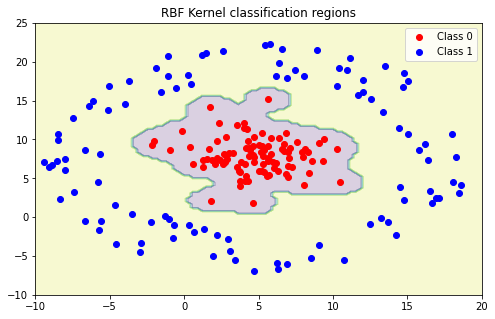

In [65]:
# Plot result
plt.figure(figsize = (8,5))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')

# Overlay colored regions
grid_x,grid_y = np.mgrid[-10:20:100j,-10:25:100j]
grid_xy = np.vstack([grid_x.ravel(),grid_y.ravel()]).T
z = svm_predict(grid_xy,X,y,opt_params,rbf_sigma).reshape((100,100))
plt.contourf(grid_x,grid_y,z,alpha = 0.2)


plt.title('RBF Kernel classification regions')
plt.legend()
plt.show()